In [74]:
import math
import numpy as np
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from scipy.interpolate import make_interp_spline
from matplotlib.patches import Circle

In [75]:
## LOADING AND PREPROCESSING DATA
data = pd.read_csv("./final_data.csv")
data = data.dropna()
data = data.iloc[10:]
data.index = range(len(data))
data.reset_index(drop=True, inplace=True)
R = data["Radius"][0]

In [137]:
## 2D PLOTTING FOR VISUALIZATION
def plot_2d_seismic_paths_multiple(data_lists, scale_factor=1.2, interpolation_val=50, R=R, ch ="p"):
    """
    Plots multiple seismic wave propagation paths with simple color scheme on white background.
    """
    fig, ax = plt.subplots(figsize=(12, 12))
    max_r = 0

    # White background settings
    ax.set_facecolor('#FFFFFF')
    fig.patch.set_facecolor('#FFFFFF')

    # Just 2-3 distinct colors
    colors = ['#FF0000', '#0000FF', '#000000']  # Red, Blue, Black

    for idx, data_list in enumerate(data_lists):
        # Extract radius and angle
        r = np.array([point['R'] for point in data_list])
        theta = np.array([point['theta'] for point in data_list])
        max_r = max(max_r, np.max(r))

        # Plot positive theta path
        adjusted_theta = theta + np.pi / 2
        x = r * np.cos(adjusted_theta)
        y = r * np.sin(adjusted_theta)

        #################################################################################
        # Smooth interpolation for positive path
        t = np.arange(len(x))
        t_dense = np.linspace(t.min(), t.max(), interpolation_val)
        k = min(3, len(x) - 1)
        #################################################################################
        spl_x = make_interp_spline(t, x, k=k)
        spl_y = make_interp_spline(t, y, k=k)

        x_smooth = spl_x(t_dense)
        y_smooth = spl_y(t_dense)

        # Plot first path
        color = colors[idx % len(colors)]
        ax.plot(x_smooth, y_smooth, color=color, alpha=1.0, lw=2)

        # Plot negative theta path (mirror image)
        x_neg = r * np.cos(-adjusted_theta + np.pi)
        y_neg = r * np.sin(-adjusted_theta + np.pi)

        # Smooth interpolation for negative path
        spl_x_neg = make_interp_spline(t, x_neg, k=k)
        spl_y_neg = make_interp_spline(t, y_neg, k=k)

        x_smooth_neg = spl_x_neg(t_dense)
        y_smooth_neg = spl_y_neg(t_dense)

        # Plot second path
        ax.plot(x_smooth_neg, y_smooth_neg, color=color, alpha=1.0, lw=2)

    # Outer circle (R)
    circle_outer = Circle((0, 0), R, fill=False, edgecolor='#000000',
                         linestyle='--', linewidth=1.5)
    ax.add_patch(circle_outer)

    # Inner circle (1864)
    circle_inner = Circle((0, 0), 1864, fill=True, facecolor='#0000FF',
                         alpha=0.1, edgecolor='#000000', linestyle='-',
                         linewidth=1.5)
    ax.add_patch(circle_inner)

    # Plot settings
    ax.set_xlabel('X Distance (km)', color='black', fontsize=12)
    ax.set_ylabel('Y Distance (km)', color='black', fontsize=12)
    ax.set_title(f'Seismic Wave Propagation Paths for {ch} - WAVE', pad=20,
                color='black', fontsize=14)

    # Remove grid and set aspect ratio
    ax.grid(False)
    ax.set_aspect('equal')

    # Set axis limits
    max_plot_r = max_r * scale_factor
    ax.set_xlim([-max_plot_r, max_plot_r])
    ax.set_ylim([-max_plot_r, max_plot_r])

    # Style axis lines and ticks
    for spine in ax.spines.values():
        spine.set_color('black')
        spine.set_linewidth(1)

    ax.tick_params(axis='both', colors='black', width=1, length=6)

    plt.show()

In [138]:
## TRACING THE COMPLETE PATH
class path_find:
    def __init__(self, data):
        """
            data : DataFrame with columns: Vs, Vp, Radius.
        """
        self.data = data

    def path_s(self, init_angle):
        ## TRACING S-WAVE PATH
        ch='s'
        i = math.radians(init_angle)
        count = 1
        data_saved = []
        R1 = self.data["Radius"][0]
        R2 = self.data["Radius"][1]
        r_input = math.sin(i)*R2/R1
        
        
        # Not Allowing Rays to go out from the sphere
        if not (abs(r_input)<=1):
            return -1
        r = math.asin(r_input)
        data_saved.append({
            'R': self.data["Radius"][0],
            "theta": 0,
            'r' : r
        })

        R = self.data["Radius"][0]
        r2 = self.data["Radius"][0]
        t2 = r2*math.sin(i)/R
        # Avoid errors
        if not (-1 <= t2 <= 1):
            return data_saved
        theta = i-math.asin(t2)
        n_points = self.data.shape[0]
        while True:
            if(count+1>=n_points):
                break
            R1 = self.data["Radius"].iloc[count]
            R2 = self.data["Radius"].iloc[count + 1]
            V1 = self.data["V" + ch].iloc[count-1]
            V2 = self.data["V" + ch].iloc[count]

            # Save the current point with refraction angle
            data_saved.append({
                'R': R1,
                "theta": theta,
                "r" : r
            })
            #### DON'T CONTNUE RAY PATH WHEN VELOCITY IS ZERO #####
            if V2 == 0:
                return data_saved

            if R1==0 or R2==0:
                break
            r_input = math.sin(i) * V1 / V2

            # Avoid Errors
            if not (abs(r_input) <= 1):
                break

            r = math.asin(r_input)

            alpha = math.asin(R2/R1)
            if(r > alpha):
                break
            i_input = R1* math.sin(r)/R2

            # Avoid Errors
            if not (abs(i_input) < 1):
                break

            i = math.asin(i_input)

            # Avoid Errors
            if(R2 >= R):
                return -1

            count += 1
            theta += i - r

        ## BACKTRACKING
        i = r
        theta+= math.pi - 2*r
        while True:
            R1 = self.data["Radius"].iloc[count]
            R2 = self.data["Radius"].iloc[count - 1]
            V1 = self.data["V" + ch].iloc[count]
            V2 = self.data["V" + ch].iloc[count-1]
            r_input = V2*math.sin(i)/V1

            #### DON'T CONTNUE RAY PATH WHEN VELOCITY IS ZERO #####
            if V2 == 0 or V1==0:
                return -1

            # Saving the Current Point with refraction anglr
            data_saved.append({
                'R':R1,
                "theta": theta,
                "r" : r
            })
            if( R2 == R ):
                break
            
            
            # Avoid Errors
            if not ( abs(r_input) <= 1):
                return -1
            r = math.asin(r_input)
            i_input = math.sin(r) * R1/R2
            
            # Avoid Errors
            if not (abs(i_input)<=1):
                return -1
            i = math.asin(i_input)
            count-=1
            theta+= r-i
        return data_saved


    def path_p(self, init_angle):
        ## TRACING P-WAVE PATH
        ch='p'
        i = math.radians(init_angle)
        count = 1
        data_saved = []

        R1 = self.data["Radius"][0]
        R2 = self.data["Radius"][1]
        r_input = math.sin(i)*R2/R1
        
        # Avoid Errors
        if not (abs(r_input)<=1):
            return -1
        r = math.asin(r_input)

        # Save the current point with refraction angle
        data_saved.append({
            'R': self.data["Radius"][0],
            "theta": 0,
            "r" : r
        })

        R = self.data["Radius"][0]
        r = self.data["Radius"][0]
        t2 = r*math.sin(i)/R
        
        # Avoid Errors
        if not (-1 <= t2 <= 1):
            return data_saved
        
        theta = i-math.asin(t2)
        n_points = self.data.shape[0]
        while True:
            if(count+1>=n_points):
                break

            R1 = self.data["Radius"].iloc[count]
            R2 = self.data["Radius"].iloc[count + 1]
            V1 = self.data["V" + ch].iloc[count-1]
            V2 = self.data["V" + ch].iloc[count]

            # Save the current point with refraction angle
            data_saved.append({
                'R': R1,
                "theta": theta,
                "r" : r
            })
            #### DON'T CONTNUE RAY PATH WHEN VELOCITY IS ZERO #####
            if V2 == 0:
                return -1
            
            # Avoid Errors
            if R1==0 or R2==0:
                break
            r_input = math.sin(i) * V1 / V2

            # Avoid Errors
            if not (abs(r_input) <= 1):
                break

            r = math.asin(r_input)

            alpha = math.asin(R2/R1)
            if(r > alpha):
                break
            i_input = R1* math.sin(r)/R2
            
            # Avoid Errors
            if not (abs(i_input) < 1):
                break

            i = math.asin(i_input)

            # Avoid Errors
            if(R2 >= R):
                return -1

            count += 1
            theta += i - r

        ## BACKTRACKING
        i = r
        theta+= math.pi - 2*r
        while True:
            R1 = self.data["Radius"].iloc[count]
            R2 = self.data["Radius"].iloc[count - 1]
            V1 = self.data["V" + ch].iloc[count]
            V2 = self.data["V" + ch].iloc[count-1]
            r_input = V2*math.sin(i)/V1

            #### DON'T CONTNUE RAY PATH WHEN VELOCITY IS ZERO #####
            if V2 == 0 or V1==0:
                return -1

            # Save the current point with refraction angle
            data_saved.append({
                'R':R1,
                "theta": theta,
                "r" : r
            })
            if( R2 == R ):
                break
            
            # Avoid Errors
            if not ( abs(r_input) <= 1):
                return -1
            r = math.asin(r_input)
            i_input = math.sin(r) * R1/R2
            
            # Avoid Errors
            if not (abs(i_input)<=1):
                return -1
            i = math.asin(i_input)
            count-=1
            theta+= r-i
        return data_saved


In [139]:
# Shadow Zone
def shadow_zone_for_p(data):
    pf = path_find(data)
    start_angle = []
    end_angle = []
    i = 0
    while (i<=90):
        data_saved_p = pf.path_p(init_angle=i)
        if(data_saved_p==-1):
            start_angle.append(i)
            while(i<=90 and data_saved_p==-1):
                i+=1
                data_saved_p = pf.path_p(init_angle=i)
            end_angle.append(i)
        i+=1
    max=0
    for i in range(len(start_angle)):
        if(abs(end_angle[i]-start_angle[i]) > abs(end_angle[max]-start_angle[max])):
            max = i
    return start_angle[max],end_angle[max]

In [140]:
## SHADOW ZONES
start_angle, end_angle = shadow_zone_for_p(data)
pf2 = path_find(data)
shadow_zone_start_data = pf2.path_p(init_angle = start_angle-1)
shadow_zone_end_data = pf2.path_p(init_angle = end_angle+1)

In [141]:
# TRACING COMPLETE PATHS
pf = path_find(data)
all_s_paths_data = []
all_p_paths_data = []

for i in range(5,90,5):
    data_saved_p = pf.path_p(init_angle=i)
    data_saved_s = pf.path_s(init_angle=i)
    if not(data_saved_p==-1):
        all_p_paths_data.append(data_saved_p)
    if not(data_saved_s==-1):
        all_s_paths_data.append(data_saved_s)

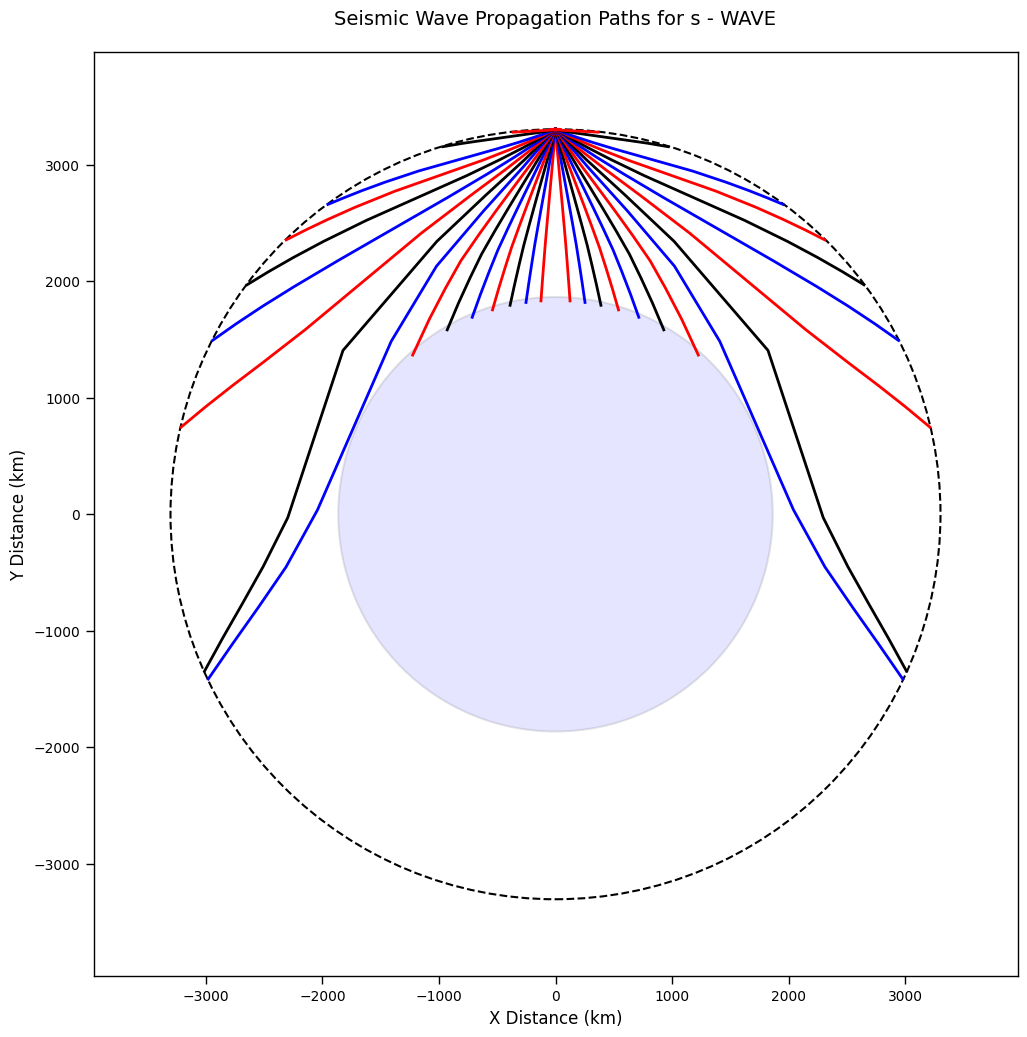

In [142]:
plot_2d_seismic_paths_multiple(all_s_paths_data,interpolation_val=10,ch="s")

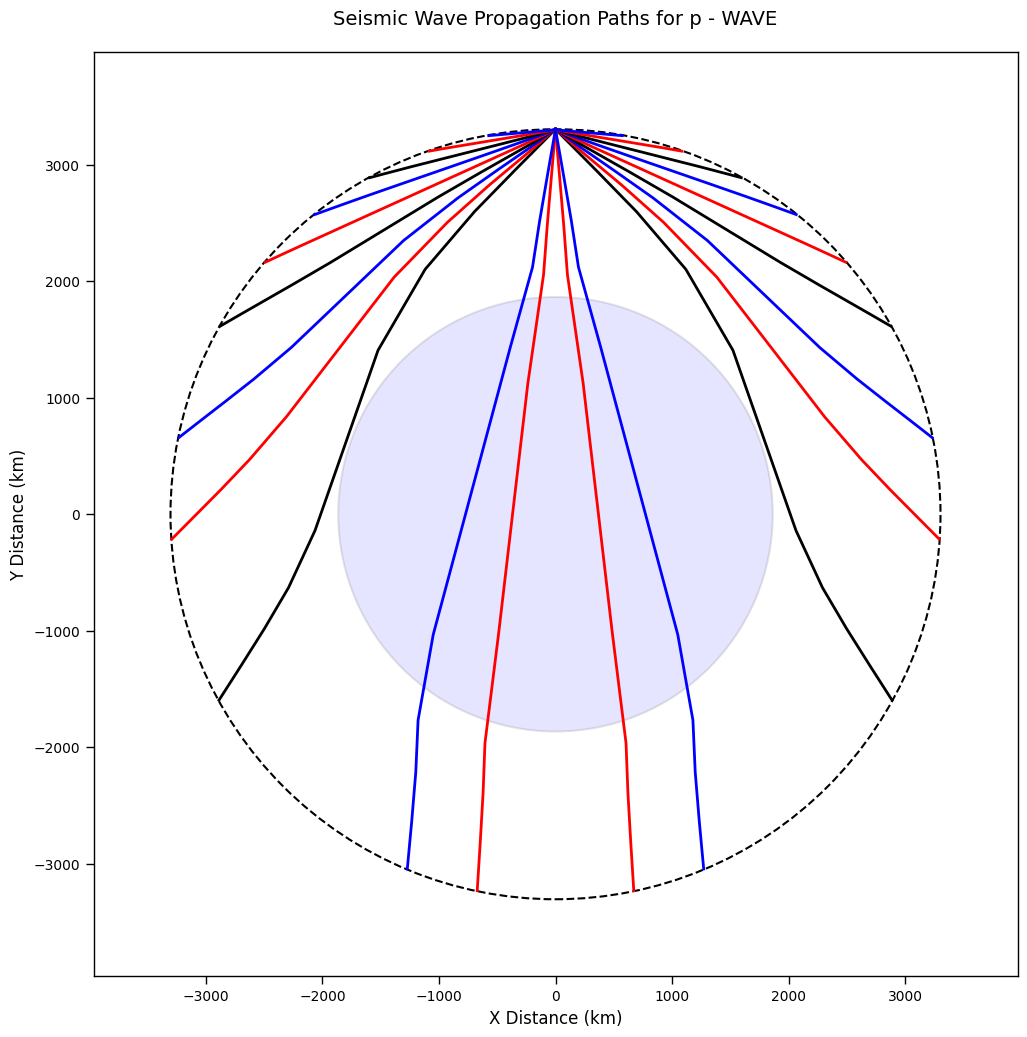

In [143]:
plot_2d_seismic_paths_multiple(all_p_paths_data,interpolation_val=10, ch="p")

In [107]:
import numpy as np
import torch
import torch.nn as nn
import plotly.graph_objects as go
from scipy.interpolate import make_interp_spline

class SeismicPINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(4, 32),  # Input: t, r, theta, phi
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 1)   # Output: wave properties
        )
    
    def forward(self, t, r, theta, phi):
        x = torch.cat([t, r, theta, phi], dim=1)
        return self.net(x)

def plot_seismic_paths_3d_interactive(data_lists, rotations=[0, 60, 120, 180, 240, 300], scale_factor=1.2, interpolation_val=10, R=R):
    """
    Creates an interactive 3D plot of seismic wave propagation paths using Plotly.
    Parameters:
    data_lists: List of path data points
    rotations: List of rotation angles in degrees
    scale_factor: Factor to scale the plot axes
    interpolation_val: Number of interpolation points
    R: Radius of the Mars
    """
    # Initialize PINN model for physics calculations
    pinn = SeismicPINN()
    
    colors = ['red', 'blue', 'black']
    max_r = 0
    fig = go.Figure()
    
    # Plot paths for each rotation angle
    for rotation_angle in rotations:
        rotation_rad = np.radians(rotation_angle)
        for idx, data_list in enumerate(data_lists):
            r = np.array([point['R'] for point in data_list])
            theta = np.array([point['theta'] for point in data_list])
            max_r = max(max_r, np.max(r))
            
            adjusted_theta = theta + np.pi / 2
            x = r * np.cos(adjusted_theta)
            y = r * np.sin(adjusted_theta)
            z = np.zeros_like(x)
            
            # Calculate physics properties with PINN
            with torch.no_grad():
                t = torch.linspace(0, 1, len(r)).reshape(-1, 1)
                r_torch = torch.FloatTensor(r).reshape(-1, 1)
                theta_torch = torch.FloatTensor(theta).reshape(-1, 1)
                phi_torch = torch.zeros_like(t)
                _ = pinn(t, r_torch, theta_torch, phi_torch)  # Calculate physics properties
            
            # Smooth interpolation
            t = np.arange(len(x))
            t_dense = np.linspace(t.min(), t.max(), interpolation_val)
            k = min(3, len(x) - 1)
            spl_x = make_interp_spline(t, x, k=k)
            spl_y = make_interp_spline(t, y, k=k)
            x_smooth = spl_x(t_dense)
            y_smooth = spl_y(t_dense)
            z_smooth = np.zeros_like(x_smooth)
            
            # Apply rotation around y-axis
            x_rot = x_smooth * np.cos(rotation_rad) - z_smooth * np.sin(rotation_rad)
            y_rot = y_smooth
            z_rot = x_smooth * np.sin(rotation_rad) + z_smooth * np.cos(rotation_rad)
            
            fig.add_trace(go.Scatter3d(x=x_rot, y=y_rot, z=z_rot, mode='lines',
                                     line=dict(color=colors[idx % len(colors)], width=3),
                                     name=f'Path {idx+1} (Rot {rotation_angle}°)'))
    
    # Create wireframe sphere for outer surface (Mars-like)
    phi = np.linspace(0, 2*np.pi, 100)
    theta = np.linspace(0, np.pi, 50)
    phi, theta = np.meshgrid(phi, theta)
    x = R * np.sin(theta) * np.cos(phi)
    y = R * np.sin(theta) * np.sin(phi)
    z = R * np.cos(theta)
    
    # Apply a Mars-like color scale
    fig.add_trace(go.Surface(x=x, y=y, z=z, colorscale='YlOrRd', opacity=0.4, showscale=False))
    
    # Create wireframe sphere for inner core with red color
    core_radius = 1864  # Example core radius
    x_inner = core_radius * np.sin(theta) * np.cos(phi)
    y_inner = core_radius * np.sin(theta) * np.sin(phi)
    z_inner = core_radius * np.cos(theta)
    fig.add_trace(go.Surface(x=x_inner, y=y_inner, z=z_inner, colorscale='reds', opacity=0.5, showscale=False))
    
    # Set plot layout with top-down view
    fig.update_layout(scene=dict(
        xaxis_title='X Distance (km)',
        yaxis_title='Y Distance (km)',
        zaxis_title='Z Distance (km)',
        aspectmode='cube',
        xaxis=dict(range=[-max_r * scale_factor, max_r * scale_factor]),
        yaxis=dict(range=[-max_r * scale_factor, max_r * scale_factor]),
        zaxis=dict(range=[-max_r * scale_factor, max_r * scale_factor]),
        camera=dict(eye=dict(x=0, y=0, z=1.5))  # Set camera view to top-down
    ),
    title='Interactive 3D Seismic Wave Propagation Paths',
    showlegend=True)
    
    fig.show()

In [108]:
plot_seismic_paths_3d_interactive(all_p_paths_data)

In [19]:
plot_seismic_paths_3d_interactive(all_s_paths_data)